In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import optuna
from collections import Counter
import time
import warnings
import gc

import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

In [3]:
    
df=pd.read_parquet('cleaned_births_14_15.parquet')

xtrain, xtest, ytrain, ytest = train_test_split\
(df.drop(['survival'],axis=1), df.survival, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)

xbal, ybal = rus.fit_resample(xtrain, ytrain)

In [4]:
del df
from helper import wrapper, feature_importances, performance_result, confusion_matrix_plot

In [5]:

df_xbal=pd.concat([ybal,xbal],axis=1) # This Dataframe contains training data with the target and all other features 






### The below code creates a custom performance metric.

In this case that custom metric is nothing more than the false positive rate. However, just about any expression constructed from the four values that make up the confusion matrix could be theorhetically used.

The false positive rate metric was created here based on the real world applications of a predictive model for infant mortality. That is to say, if a model such as the models trained in this notebook were ever to be used in a real world scenario the most costly kind of error that could be made would be a false positive. For this data, a false positive would result in an infant being classified as likely to survive when infact said infant was not likely to survive. To combat this we will use the false positive rate as a cost function to be minimized. 


In [39]:
def fp_rate(y,y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return(fp/(fp+tn))
false_positive_rate=make_scorer(fp_rate)





### GradientBoostingClassifier, Maximizing precision.
Below is a demonstration of the process to optimize hyperparameters for a GradientBoostingClassifier using precision as the metric to be maximized. A sample of just 1000 rows of the balanced training data is used for the repeated crossvalidation as the processing power of the computer this notebook is being written on is limited. This repo contains a notebook in which a more rigorus process is employed.  

In [8]:
subsample=df_xbal.sample(1000)
Column_Transformer=wrapper(None).col_transform 
# a subset of 1000 rows is selected primarily for demonstrational purposes
subx,suby=subsample.drop(columns=['survival']),subsample['survival']
def objective(trial):
    
    x, y = Column_Transformer.fit_transform(subx),suby

    
    
    params_gbc={'n_estimators' : trial.suggest_int("n_estimators", 250, 650),
    'learning_rate' : trial.suggest_float("learning_rate", 0.05, 0.25),
    'max_features' : trial.suggest_int("max_features",32,300),
    'min_samples_split' : trial.suggest_float("min_samples_split", 0.1, 1.0),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,4),
    'max_depth' : trial.suggest_int('max_depth',2,10)}
    classifier_obj = GradientBoostingClassifier(**params_gbc)

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5,scoring=make_scorer(precision_score))
    mean_metric = score.mean()
    return mean_metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2023-03-19 00:19:29,241] A new study created in memory with name: no-name-2a9431e7-ccc1-4f5c-8485-5cf0cbac68be
[I 2023-03-19 00:19:32,805] Trial 0 finished with value: 0.8058675498113423 and parameters: {'n_estimators': 295, 'learning_rate': 0.17032531147453206, 'max_features': 147, 'min_samples_split': 0.3526628503106751, 'min_samples_leaf': 3, 'max_depth': 9}. Best is trial 0 with value: 0.8058675498113423.
[I 2023-03-19 00:19:36,177] Trial 1 finished with value: 0.7935577334216696 and parameters: {'n_estimators': 499, 'learning_rate': 0.21404945094865674, 'max_features': 164, 'min_samples_split': 0.12584466786623727, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 0 with value: 0.8058675498113423.
[I 2023-03-19 00:19:37,682] Trial 2 finished with value: 0.7925617356897214 and parameters: {'n_estimators': 340, 'learning_rate': 0.2484935390434891, 'max_features': 140, 'min_samples_split': 0.6032757284159883, 'min_samples_leaf': 3, 'max_depth': 6}. Best is trial 0 with value: 

[I 2023-03-19 00:20:08,988] Trial 26 finished with value: 0.7956976873988906 and parameters: {'n_estimators': 421, 'learning_rate': 0.20667579471260855, 'max_features': 229, 'min_samples_split': 0.4480567340818926, 'min_samples_leaf': 3, 'max_depth': 5}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:20:10,957] Trial 27 finished with value: 0.8037098333466371 and parameters: {'n_estimators': 526, 'learning_rate': 0.1738508306890714, 'max_features': 272, 'min_samples_split': 0.5640715208030743, 'min_samples_leaf': 1, 'max_depth': 7}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:20:12,136] Trial 28 finished with value: 0.8035860181254189 and parameters: {'n_estimators': 483, 'learning_rate': 0.23251282357812547, 'max_features': 178, 'min_samples_split': 0.3109260679447632, 'min_samples_leaf': 2, 'max_depth': 3}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:20:13,843] Trial 29 finished with value: 0.8070826438616272 and parameters:

[I 2023-03-19 00:21:03,684] Trial 52 finished with value: 0.8036923145757571 and parameters: {'n_estimators': 536, 'learning_rate': 0.2405422948064834, 'max_features': 233, 'min_samples_split': 0.5312134879651795, 'min_samples_leaf': 2, 'max_depth': 2}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:05,127] Trial 53 finished with value: 0.7909768590614058 and parameters: {'n_estimators': 629, 'learning_rate': 0.23945534511904684, 'max_features': 213, 'min_samples_split': 0.6042062091513738, 'min_samples_leaf': 2, 'max_depth': 2}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:06,306] Trial 54 finished with value: 0.7942203663385797 and parameters: {'n_estimators': 522, 'learning_rate': 0.2225790345843937, 'max_features': 190, 'min_samples_split': 0.7218792069294757, 'min_samples_leaf': 2, 'max_depth': 3}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:07,479] Trial 55 finished with value: 0.8020666351422487 and parameters: 

[I 2023-03-19 00:21:50,363] Trial 78 finished with value: 0.8019344968756734 and parameters: {'n_estimators': 546, 'learning_rate': 0.21883808047089678, 'max_features': 161, 'min_samples_split': 0.46823251097670315, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:51,648] Trial 79 finished with value: 0.795957392990641 and parameters: {'n_estimators': 574, 'learning_rate': 0.23212920966031178, 'max_features': 220, 'min_samples_split': 0.5337949680011659, 'min_samples_leaf': 3, 'max_depth': 2}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:54,147] Trial 80 finished with value: 0.808458954206527 and parameters: {'n_estimators': 513, 'learning_rate': 0.24308816259676308, 'max_features': 141, 'min_samples_split': 0.26279067816376916, 'min_samples_leaf': 1, 'max_depth': 10}. Best is trial 9 with value: 0.8106617367368207.
[I 2023-03-19 00:21:56,298] Trial 81 finished with value: 0.8032706783778801 and parameter

[I 2023-03-19 00:22:39,419] Trial 104 finished with value: 0.800361381972013 and parameters: {'n_estimators': 401, 'learning_rate': 0.13500537107629176, 'max_features': 200, 'min_samples_split': 0.42686521476094835, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:22:40,979] Trial 105 finished with value: 0.8042099410453432 and parameters: {'n_estimators': 335, 'learning_rate': 0.13981126507363, 'max_features': 184, 'min_samples_split': 0.39090569895731503, 'min_samples_leaf': 2, 'max_depth': 8}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:22:42,164] Trial 106 finished with value: 0.7994119305121432 and parameters: {'n_estimators': 318, 'learning_rate': 0.13054762407534978, 'max_features': 150, 'min_samples_split': 0.44385557052144237, 'min_samples_leaf': 2, 'max_depth': 8}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:22:43,587] Trial 107 finished with value: 0.7975219539370483 and p

[I 2023-03-19 00:23:26,369] Trial 130 finished with value: 0.7963322682321848 and parameters: {'n_estimators': 410, 'learning_rate': 0.1246126557054683, 'max_features': 165, 'min_samples_split': 0.3983330309205064, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:23:27,770] Trial 131 finished with value: 0.8002603202663341 and parameters: {'n_estimators': 389, 'learning_rate': 0.1601250645962221, 'max_features': 138, 'min_samples_split': 0.4391121025820946, 'min_samples_leaf': 3, 'max_depth': 9}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:23:29,925] Trial 132 finished with value: 0.8027210805402906 and parameters: {'n_estimators': 630, 'learning_rate': 0.1496119310417862, 'max_features': 152, 'min_samples_split': 0.4940195107089571, 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:23:32,349] Trial 133 finished with value: 0.8031221712352279 and par

[I 2023-03-19 00:24:05,673] Trial 156 finished with value: 0.8042993914394113 and parameters: {'n_estimators': 399, 'learning_rate': 0.17983019037513645, 'max_features': 181, 'min_samples_split': 0.5131721623797632, 'min_samples_leaf': 1, 'max_depth': 10}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:07,997] Trial 157 finished with value: 0.8073178082550712 and parameters: {'n_estimators': 447, 'learning_rate': 0.2303377909058061, 'max_features': 217, 'min_samples_split': 0.4251562755884212, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:09,521] Trial 158 finished with value: 0.7928723985188588 and parameters: {'n_estimators': 443, 'learning_rate': 0.22848636153202304, 'max_features': 215, 'min_samples_split': 0.7077071237759736, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:11,404] Trial 159 finished with value: 0.8052665509958704 and

[I 2023-03-19 00:24:50,594] Trial 182 finished with value: 0.8138180894136487 and parameters: {'n_estimators': 533, 'learning_rate': 0.24433245999686007, 'max_features': 201, 'min_samples_split': 0.5225333780477456, 'min_samples_leaf': 2, 'max_depth': 2}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:52,015] Trial 183 finished with value: 0.7975823792680403 and parameters: {'n_estimators': 524, 'learning_rate': 0.24620236502509982, 'max_features': 198, 'min_samples_split': 0.48979435442011066, 'min_samples_leaf': 2, 'max_depth': 2}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:53,276] Trial 184 finished with value: 0.7988084298675522 and parameters: {'n_estimators': 536, 'learning_rate': 0.24975865060138025, 'max_features': 200, 'min_samples_split': 0.6055862139164171, 'min_samples_leaf': 2, 'max_depth': 2}. Best is trial 103 with value: 0.8142705369207646.
[I 2023-03-19 00:24:53,915] Trial 185 finished with value: 0.7972461336134945 and

### After the number of trials specified has passed, the best performing set of hyperparameters is chosen.

Every time a model undergoes hyperparameter tuning the objective function, in this case precision, is ploted as a function of the number of trials. Next, the best performing set of hyperparameters is chosen and a model is trained on the balanced training set. This trained model is then evaluated on the unbalanced test set the result of its performance is plotted with a confusion matrix under which the standard collection of classifier metrics are presented. 

Finally the model's twenty most important features are plotted with a horizontal barplot.


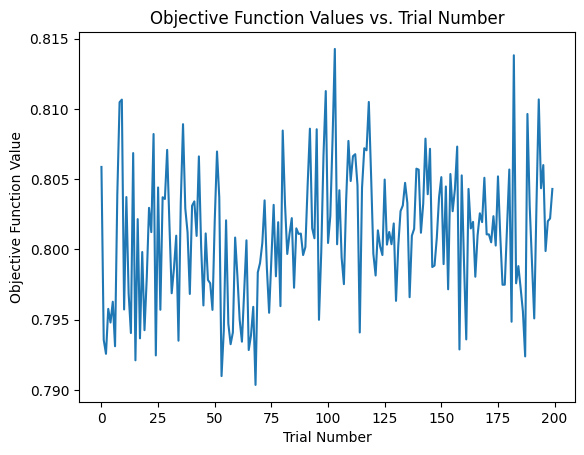

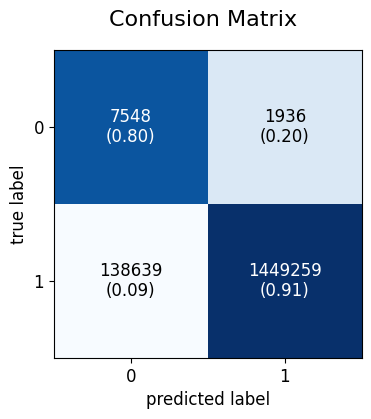

FP rate=FP/(FP+TN):  0.2041
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.9127
AUC-PR:  0.9983
f1-score:  0.9537
roc_auc:  0.8543
Accuracy:  0.9120


 {'n_estimators': 359, 'learning_rate': 0.13628876655260747, 'max_features': 201, 'min_samples_split': 0.42080538882079305, 'min_samples_leaf': 2, 'max_depth': 9} 




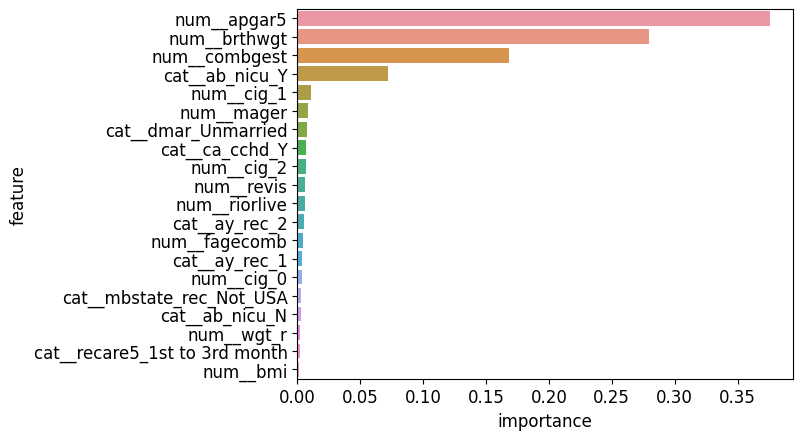

In [9]:
trials_df = study.trials_dataframe()
# Plot the objective function values versus the trial number
sns.lineplot(trials_df, x='number',y='value')
#plt.plot(trials_df['number'], trials_df['value'], 'bo-')
plt.xlabel('Trial Number')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values vs. Trial Number')
clf_tuned=wrapper(GradientBoostingClassifier(**study.best_params)).fit(xbal, ybal)
performance_result(ytest,clf_tuned.predict(xtest))

print('\n\n',study.best_params,'\n\n')

sns.set_palette("pastel")
sns.barplot(feature_importances(clf_tuned).head(20),y='feature',x='importance',orient='h')
plt.show()




#### Above we see that precision is maximized very well, and accuracy is over 90%.

However, accuracy is a less important metric than the minimization of false positives. Below we will retrain a model with the hopes of decreasing the false positive rate.

Note that the most important feature is the 5 minute apgar score.



### XGBClassifier, Minimizing False Positive Rate.
Below is a very similar process however it makes use of a different hyperparameter dictionary and minimizes instead of maximizes the false positive rate instead of the precision score.

In [40]:
subsample=df_xbal.sample(1000)
subx,suby=subsample.drop(columns=['survival']),subsample['survival']
def obj_xgbc(trial):
    
    x, y = Column_Transformer.fit_transform(subx),suby

    
    xgbc_params={'n_estimators' : trial.suggest_int("n_estimators", 200, 500),
    'learning_rate' : trial.suggest_float("learning_rate", 0.01, 0.25),
    'max_depth' : trial.suggest_int("max_depth", 1, 32),
                 'eta': trial.suggest_float("eta", 0.01, 0.5),
                 'max_delta_step': trial.suggest_int("max_delta_step", 0, 7),
                 'gamma' : trial.suggest_int("gamma", 0, 7),
                'objective' : 'binary:logistic',
                 'reg_lambda' : trial.suggest_float('reg_lambda', 0,1)}
    classifier_obj = XGBClassifier(**xgbc_params)

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5,scoring=false_positive_rate)
    accuracy = score.mean()
    return accuracy

stdy_xgbc = optuna.create_study(direction="minimize")
stdy_xgbc.optimize(obj_xgbc, n_trials=100)


[I 2023-03-19 05:08:59,489] A new study created in memory with name: no-name-2a35b01b-a586-44cd-a597-bbbd1d826469
[I 2023-03-19 05:09:04,324] Trial 0 finished with value: 0.221520618556701 and parameters: {'n_estimators': 444, 'learning_rate': 0.14341143226723177, 'max_depth': 20, 'eta': 0.22087064662376285, 'max_delta_step': 6, 'gamma': 1, 'reg_lambda': 0.6733362782738267}. Best is trial 0 with value: 0.221520618556701.
[I 2023-03-19 05:09:06,442] Trial 1 finished with value: 0.23185137457044674 and parameters: {'n_estimators': 218, 'learning_rate': 0.19973673023564562, 'max_depth': 11, 'eta': 0.017593430691993157, 'max_delta_step': 0, 'gamma': 6, 'reg_lambda': 0.41364150302672775}. Best is trial 0 with value: 0.221520618556701.
[I 2023-03-19 05:09:09,693] Trial 2 finished with value: 0.22566580756013743 and parameters: {'n_estimators': 462, 'learning_rate': 0.17015056088529404, 'max_depth': 11, 'eta': 0.16409593077378196, 'max_delta_step': 3, 'gamma': 2, 'reg_lambda': 0.3817152732801

[I 2023-03-19 05:10:08,255] Trial 25 finished with value: 0.2277491408934708 and parameters: {'n_estimators': 438, 'learning_rate': 0.05800566646633895, 'max_depth': 27, 'eta': 0.4927968565647958, 'max_delta_step': 1, 'gamma': 2, 'reg_lambda': 0.6104368544387497}. Best is trial 23 with value: 0.21535652920962195.
[I 2023-03-19 05:10:10,189] Trial 26 finished with value: 0.21327319587628865 and parameters: {'n_estimators': 470, 'learning_rate': 0.10443720208365756, 'max_depth': 14, 'eta': 0.354404157534763, 'max_delta_step': 1, 'gamma': 0, 'reg_lambda': 0.6227329732914485}. Best is trial 26 with value: 0.21327319587628865.
[I 2023-03-19 05:10:11,838] Trial 27 finished with value: 0.24213917525773193 and parameters: {'n_estimators': 476, 'learning_rate': 0.08277548206098341, 'max_depth': 1, 'eta': 0.44320552974364164, 'max_delta_step': 0, 'gamma': 0, 'reg_lambda': 0.6116442142803686}. Best is trial 26 with value: 0.21327319587628865.
[I 2023-03-19 05:10:13,846] Trial 28 finished with val

[I 2023-03-19 05:11:06,836] Trial 50 finished with value: 0.21535652920962195 and parameters: {'n_estimators': 391, 'learning_rate': 0.18933525842001026, 'max_depth': 10, 'eta': 0.4701872288767158, 'max_delta_step': 1, 'gamma': 0, 'reg_lambda': 0.9080004009448651}. Best is trial 26 with value: 0.21327319587628865.
[I 2023-03-19 05:11:08,355] Trial 51 finished with value: 0.21531357388316152 and parameters: {'n_estimators': 369, 'learning_rate': 0.18897465238187916, 'max_depth': 10, 'eta': 0.4805669069223662, 'max_delta_step': 1, 'gamma': 0, 'reg_lambda': 0.921951928127997}. Best is trial 26 with value: 0.21327319587628865.
[I 2023-03-19 05:11:09,809] Trial 52 finished with value: 0.22364690721649483 and parameters: {'n_estimators': 361, 'learning_rate': 0.21184197458245058, 'max_depth': 13, 'eta': 0.42915400217463584, 'max_delta_step': 0, 'gamma': 0, 'reg_lambda': 0.8666773323250846}. Best is trial 26 with value: 0.21327319587628865.
[I 2023-03-19 05:11:11,781] Trial 53 finished with v

[I 2023-03-19 05:12:06,028] Trial 75 finished with value: 0.22777061855670105 and parameters: {'n_estimators': 414, 'learning_rate': 0.09014650303697272, 'max_depth': 19, 'eta': 0.42353695458166984, 'max_delta_step': 0, 'gamma': 1, 'reg_lambda': 0.6547832466867722}. Best is trial 72 with value: 0.21116838487972506.
[I 2023-03-19 05:12:07,986] Trial 76 finished with value: 0.22154209621993126 and parameters: {'n_estimators': 386, 'learning_rate': 0.09533496185706301, 'max_depth': 28, 'eta': 0.46077805962645135, 'max_delta_step': 1, 'gamma': 0, 'reg_lambda': 0.7818045938290741}. Best is trial 72 with value: 0.21116838487972506.
[I 2023-03-19 05:12:11,406] Trial 77 finished with value: 0.2318298969072165 and parameters: {'n_estimators': 399, 'learning_rate': 0.11753232579198747, 'max_depth': 23, 'eta': 0.4374215061167376, 'max_delta_step': 1, 'gamma': 5, 'reg_lambda': 0.7174215558602699}. Best is trial 72 with value: 0.21116838487972506.
[I 2023-03-19 05:12:14,429] Trial 78 finished with 

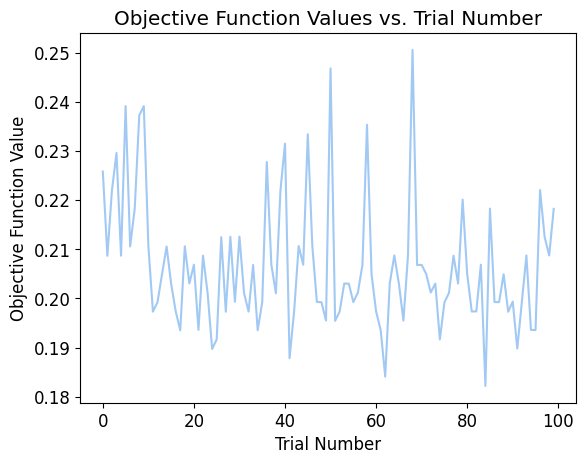

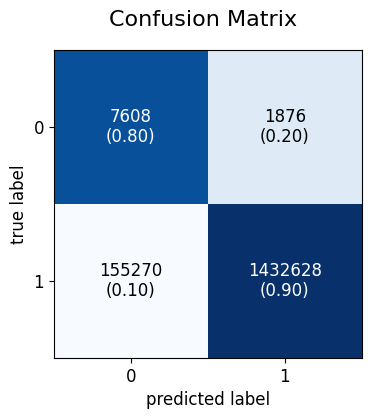

FP rate=FP/(FP+TN):  0.1978
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.9022
AUC-PR:  0.9982
f1-score:  0.9480
roc_auc:  0.8522
Accuracy:  0.9016


 {'n_estimators': 359, 'learning_rate': 0.13628876655260747, 'max_features': 201, 'min_samples_split': 0.42080538882079305, 'min_samples_leaf': 2, 'max_depth': 9} 




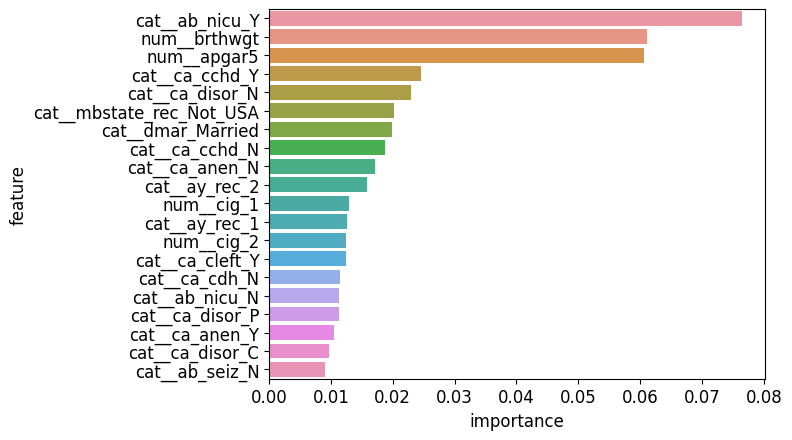

In [11]:

trials_df_xgbc = stdy_xgbc.trials_dataframe()


sns.lineplot(trials_df_xgbc, x='number',y='value')


plt.xlabel('Trial Number')

plt.ylabel('Objective Function Value')

plt.title('Objective Function Values vs. Trial Number')

static_xgbcparams=stdy_xgbc.best_params.copy()#save a static copy of best params

xgbc=wrapper(XGBClassifier(**static_xgbcparams)).fit(xbal,ybal)
performance_result(ytest,xgbc.predict(xtest))

print('\n\n',study.best_params,'\n\n')

sns.set_palette("pastel")
sns.barplot(feature_importances(xgbc).head(20),y='feature',x='importance',orient='h')
plt.show()


#### Slightly better performance with a very different approach.

Above we see a fairly similarly performing classifier except with a lower false positive rate. Note that the most important feature used for this classifier was not the five minute apgar score. A categorical feature and birthwieght were both more important features than the five minute apgar score.

### GradientBoostingClassifier, Minimizing False Positive Rate.

As the GradientBoostingClassifier has a different set of hyperparameters the paramater dictionary defined is different but the same general process is used. 


In [32]:
subsample=df_xbal.sample(1000)
# a subset of 1000 rows is selected primarily for demonstrational purposes
subx,suby=subsample.drop(columns=['survival']),subsample['survival']
def obj_gbc_minfp(trial):
    
    x, y = Column_Transformer.fit_transform(subx),suby

    
    
    params_gbc={'n_estimators' : trial.suggest_int("n_estimators", 250, 650),
    'learning_rate' : trial.suggest_float("learning_rate", 0.05, 0.25),
    'max_features' : trial.suggest_int("max_features",32,300),
    'min_samples_split' : trial.suggest_float("min_samples_split", 0.1, 1.0),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,4),
    'max_depth' : trial.suggest_int('max_depth',2,10)}
    classifier_obj = GradientBoostingClassifier(**params_gbc)

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5,scoring=false_positive_rate)
    mean_metric = score.mean()
    return mean_metric

std_gbc_minfp = optuna.create_study(direction="minimize")
std_gbc_minfp.optimize(obj_gbc_minfp, n_trials=200)


[I 2023-03-19 02:13:05,749] A new study created in memory with name: no-name-315e5f6c-71a6-46db-a79d-85d72fd1f487
[I 2023-03-19 02:13:08,328] Trial 0 finished with value: 0.2191094619666048 and parameters: {'n_estimators': 417, 'learning_rate': 0.11281551346371957, 'max_features': 227, 'min_samples_split': 0.558414108821142, 'min_samples_leaf': 2, 'max_depth': 8}. Best is trial 0 with value: 0.2191094619666048.
[I 2023-03-19 02:13:10,508] Trial 1 finished with value: 0.21306947021232733 and parameters: {'n_estimators': 411, 'learning_rate': 0.09190370915942025, 'max_features': 217, 'min_samples_split': 0.14137142528501068, 'min_samples_leaf': 3, 'max_depth': 4}. Best is trial 1 with value: 0.21306947021232733.
[I 2023-03-19 02:13:11,978] Trial 2 finished with value: 0.21304885590599879 and parameters: {'n_estimators': 489, 'learning_rate': 0.07834976888274742, 'max_features': 161, 'min_samples_split': 0.4614565315345548, 'min_samples_leaf': 4, 'max_depth': 8}. Best is trial 2 with valu

[I 2023-03-19 02:13:37,534] Trial 26 finished with value: 0.20692640692640696 and parameters: {'n_estimators': 325, 'learning_rate': 0.19383384237341866, 'max_features': 88, 'min_samples_split': 0.21293063418931152, 'min_samples_leaf': 1, 'max_depth': 7}. Best is trial 13 with value: 0.20086580086580086.
[I 2023-03-19 02:13:38,370] Trial 27 finished with value: 0.21304885590599879 and parameters: {'n_estimators': 377, 'learning_rate': 0.20712634159607618, 'max_features': 235, 'min_samples_split': 0.17001451677617674, 'min_samples_leaf': 3, 'max_depth': 2}. Best is trial 13 with value: 0.20086580086580086.
[I 2023-03-19 02:13:41,000] Trial 28 finished with value: 0.19882498453927025 and parameters: {'n_estimators': 583, 'learning_rate': 0.1837019488147546, 'max_features': 183, 'min_samples_split': 0.28744821834746137, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 28 with value: 0.19882498453927025.
[I 2023-03-19 02:13:42,960] Trial 29 finished with value: 0.2069057926200783 and 

[I 2023-03-19 02:14:55,675] Trial 52 finished with value: 0.2069676355390641 and parameters: {'n_estimators': 577, 'learning_rate': 0.18077029827077754, 'max_features': 287, 'min_samples_split': 0.24172112146416438, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 51 with value: 0.19682539682539682.
[I 2023-03-19 02:14:59,685] Trial 53 finished with value: 0.19680478251906824 and parameters: {'n_estimators': 520, 'learning_rate': 0.15685738413753086, 'max_features': 226, 'min_samples_split': 0.1840883307107235, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 53 with value: 0.19680478251906824.
[I 2023-03-19 02:15:03,826] Trial 54 finished with value: 0.20292723149866004 and parameters: {'n_estimators': 544, 'learning_rate': 0.14202558960662556, 'max_features': 224, 'min_samples_split': 0.18367834424392343, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 53 with value: 0.19680478251906824.
[I 2023-03-19 02:15:07,185] Trial 55 finished with value: 0.1948051948051948 a

[I 2023-03-19 02:16:30,646] Trial 78 finished with value: 0.20294784580498865 and parameters: {'n_estimators': 571, 'learning_rate': 0.17029561609286806, 'max_features': 225, 'min_samples_split': 0.24320383544939086, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 55 with value: 0.1948051948051948.
[I 2023-03-19 02:16:33,227] Trial 79 finished with value: 0.20492681921253347 and parameters: {'n_estimators': 531, 'learning_rate': 0.15009005307951664, 'max_features': 177, 'min_samples_split': 0.33035215629625875, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 55 with value: 0.1948051948051948.
[I 2023-03-19 02:16:37,868] Trial 80 finished with value: 0.2070294784580499 and parameters: {'n_estimators': 510, 'learning_rate': 0.1649190773464906, 'max_features': 258, 'min_samples_split': 0.16571829537649543, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 55 with value: 0.1948051948051948.
[I 2023-03-19 02:16:41,893] Trial 81 finished with value: 0.20492681921253347 and 

[I 2023-03-19 02:18:14,710] Trial 104 finished with value: 0.20492681921253353 and parameters: {'n_estimators': 577, 'learning_rate': 0.17233606570691185, 'max_features': 198, 'min_samples_split': 0.25299655744238714, 'min_samples_leaf': 2, 'max_depth': 10}. Best is trial 55 with value: 0.1948051948051948.
[I 2023-03-19 02:18:18,459] Trial 105 finished with value: 0.20896722325293754 and parameters: {'n_estimators': 598, 'learning_rate': 0.15458227760051077, 'max_features': 210, 'min_samples_split': 0.2871517626297008, 'min_samples_leaf': 2, 'max_depth': 9}. Best is trial 55 with value: 0.1948051948051948.
[I 2023-03-19 02:18:23,422] Trial 106 finished with value: 0.19074417645846217 and parameters: {'n_estimators': 623, 'learning_rate': 0.1819654838726862, 'max_features': 277, 'min_samples_split': 0.2194545651467554, 'min_samples_leaf': 2, 'max_depth': 8}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:18:28,568] Trial 107 finished with value: 0.196866625438054 an

[I 2023-03-19 02:20:01,732] Trial 130 finished with value: 0.20896722325293754 and parameters: {'n_estimators': 612, 'learning_rate': 0.20600973501182607, 'max_features': 173, 'min_samples_split': 0.15636772231930907, 'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:20:04,716] Trial 131 finished with value: 0.21106988249845396 and parameters: {'n_estimators': 606, 'learning_rate': 0.16839075813019946, 'max_features': 166, 'min_samples_split': 0.19259239407228487, 'min_samples_leaf': 2, 'max_depth': 6}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:20:07,698] Trial 132 finished with value: 0.21104926819212536 and parameters: {'n_estimators': 600, 'learning_rate': 0.16118931111535265, 'max_features': 183, 'min_samples_split': 0.23467029911487763, 'min_samples_leaf': 2, 'max_depth': 6}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:20:11,147] Trial 133 finished with value: 0.206988249845

[I 2023-03-19 02:21:30,300] Trial 156 finished with value: 0.20904968047825187 and parameters: {'n_estimators': 570, 'learning_rate': 0.18198179573517997, 'max_features': 152, 'min_samples_split': 0.14459865379708298, 'min_samples_leaf': 2, 'max_depth': 6}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:21:32,379] Trial 157 finished with value: 0.20296846011131725 and parameters: {'n_estimators': 442, 'learning_rate': 0.15866999072205026, 'max_features': 178, 'min_samples_split': 0.1262286663429063, 'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:21:36,146] Trial 158 finished with value: 0.22112966398680686 and parameters: {'n_estimators': 505, 'learning_rate': 0.185436087222363, 'max_features': 288, 'min_samples_split': 0.3183090108346382, 'min_samples_leaf': 4, 'max_depth': 10}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:21:39,225] Trial 159 finished with value: 0.196846011131725

[I 2023-03-19 02:23:03,995] Trial 182 finished with value: 0.20296846011131725 and parameters: {'n_estimators': 582, 'learning_rate': 0.19300954607599624, 'max_features': 273, 'min_samples_split': 0.15058802811405536, 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:23:08,489] Trial 183 finished with value: 0.20902906617192327 and parameters: {'n_estimators': 611, 'learning_rate': 0.18226853540071222, 'max_features': 267, 'min_samples_split': 0.2003346707075455, 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:23:13,336] Trial 184 finished with value: 0.20086580086580086 and parameters: {'n_estimators': 605, 'learning_rate': 0.19148802139917145, 'max_features': 284, 'min_samples_split': 0.16199115688636723, 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 106 with value: 0.19074417645846217.
[I 2023-03-19 02:23:17,026] Trial 185 finished with value: 0.2029066171923

### Below we see the performance of using the GradientBoostingClassifier.

Note that the method of hyperparameter tuning below is almost identical to that of the XGBoost classifier above. Both minimized false positive to almost identical thresholds. However, when looking at feature importance we notice that the GBC below gives more power to a smaller number features and overall the GBC performs slightly better than the above XGBoost classifier.

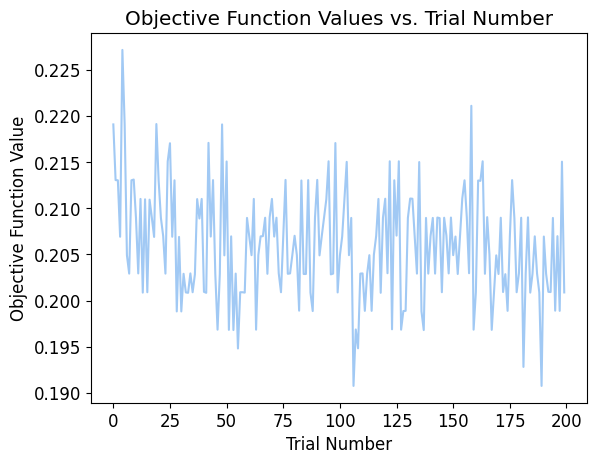

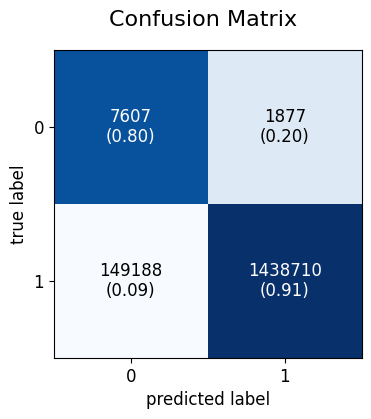

FP rate=FP/(FP+TN):  0.1979
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.9060
AUC-PR:  0.9983
f1-score:  0.9501
roc_auc:  0.8541
Accuracy:  0.9054


 {'n_estimators': 623, 'learning_rate': 0.1819654838726862, 'max_features': 277, 'min_samples_split': 0.2194545651467554, 'min_samples_leaf': 2, 'max_depth': 8} 




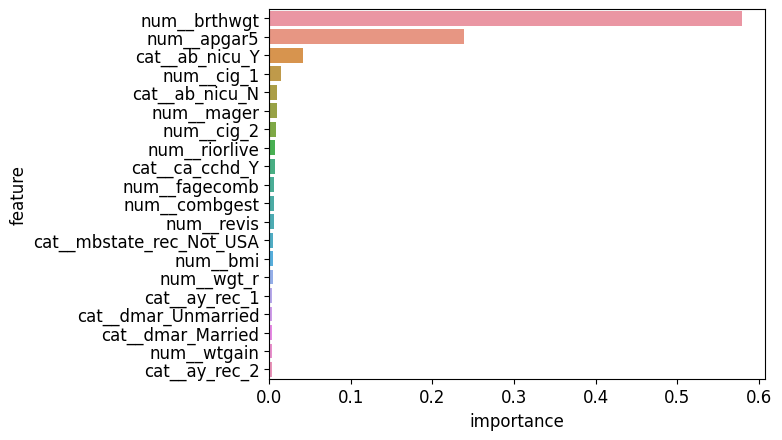

In [33]:
trials_df_gbc_minfp = std_gbc_minfp.trials_dataframe()

sns.lineplot(trials_df_gbc_minfp, x='number',y='value')

plt.xlabel('Trial Number')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values vs. Trial Number')

static_gbc_minfp_params=std_gbc_minfp.best_params.copy()

gbc_mfp=wrapper(GradientBoostingClassifier(**static_gbc_minfp_params)).fit(xbal, ybal)
performance_result(ytest,gbc_mfp.predict(xtest))

print('\n\n',static_gbc_minfp_params,'\n\n')

sns.set_palette("pastel")
sns.barplot(feature_importances(gbc_mfp).head(20),y='feature',x='importance',orient='h')
plt.show()

In [41]:
import joblib


In [43]:
joblib.dump(gbc_mfp,'GBC_small')

['GBC_small']

In [45]:
import os
os.listdir()

['Untitled1.ipynb',
 '.DS_Store',
 'Untitled.ipynb',
 'cleaned_births_14_15.parquet',
 '__pycache__',
 'Capstone.ipynb',
 'README.md',
 'temp.ipynb',
 'Final.ipynb',
 'GBC_small',
 'LinkCO15Guide.pdf',
 'helper.py',
 '.gitattributes',
 'xgboost.joblid',
 '.ipynb_checkpoints',
 '.git',
 'more_data_testing.ipynb',
 'Visualizations.ipynb',
 'mult_years.ipynb',
 'Natality_final.ipynb']